In [577]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


<h1>Loading data from stooq</h1>
Stooq file contains few useless columns, so we will drop them and rename to English

In [578]:
pfe = pd.read_csv("pfe_us_d.csv")
wmt = pd.read_csv("wmt_us_d.csv")
ko = pd.read_csv("ko_us_d.csv")
ale = pd.read_csv("ale_d-2.csv")

tickers = [pfe, wmt, ko, ale]
tickers_str = ['pfe','wmt','ko','ale']

for ticker_str, ticker in zip(tickers_str,tickers):
    close_str = 'Close_' + ticker_str
    ticker.drop(labels=['Otwarcie','Najwyzszy','Najnizszy','Wolumen'], axis=1, inplace=True)
    ticker.rename(columns={'Data':'Date', "Zamkniecie":close_str}, inplace=True)
    ticker.set_index('Date', inplace=True)


Dealing with prices in finance not very useful, changind data to percentage changes

In [579]:
pfe_pct_change = pfe.pct_change()
wmt_pct_change = wmt.pct_change()
ko_pct_change = ko.pct_change()
ale_pct_change = ale.pct_change()

Merging data together

In [580]:
merged_data = pd.merge(pfe_pct_change, wmt_pct_change, left_index=True, right_index=True)
merged_data = pd.merge(merged_data, ko_pct_change, left_index=True, right_index=True)
merged_data = pd.merge(merged_data, ale_pct_change, left_index=True, right_index=True)
merged_data

,Close_pfe,Close_wmt,Close_ko,Close_ale
Date,,,,
2020-10-12,NaN,NaN,NaN,NaN
2020-10-13,0.002138,0.013729,-0.017042,0.142857
2020-10-14,-0.001053,-0.015626,-0.002013,-0.050500
2020-10-15,-0.008402,0.004092,-0.002573,0.042917
2020-10-16,0.038316,0.001265,0.000805,0.028149
...,...,...,...,...
2021-11-05,0.108552,-0.006941,0.004240,0.106742
2021-11-08,-0.005760,-0.006390,-0.008973,-0.031574
2021-11-09,-0.021312,0.003484,0.002840,-0.112276


<h2>Describing data</h2>

- WMT and ALE mean change not very good, in real scenario we'll probably eliminate assets with <strong>negative E(R) </strong>

- ALE looks very volatile

- And also ALE gave us largest max return
    


In [581]:
merged_data.describe()

,Close_pfe,Close_wmt,Close_ko,Close_ale
count,266.000000,266.000000,266.000000,266.000000
mean,0.001298,-0.000075,0.000597,-0.001486
std,0.016404,0.009913,0.010112,0.029509
min,-0.052899,-0.064820,-0.038887,-0.112276
25%,-0.006896,-0.005818,-0.003909,-0.019658
50%,0.000000,-0.000207,0.000844,-0.001726
75%,0.007229,0.005945,0.006077,0.012928
max,0.108552,0.027047,0.063087,0.142857


Let's see histogram to double check statistics above

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Return')

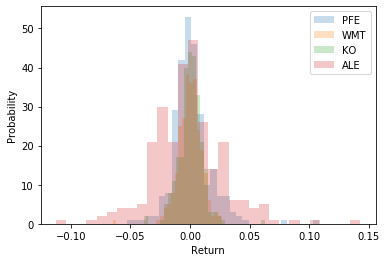

In [695]:
plt.hist(merged_data['Close_pfe'], density=False, bins=30, alpha=0.25, label='PFE')
plt.hist(merged_data['Close_wmt'], alpha=0.25,bins=30, label='WMT')
plt.hist(merged_data['Close_ko'], alpha=0.25, bins=30, label='KO')
plt.hist(merged_data['Close_ale'], alpha=0.25, bins=30, label='ALE')


plt.legend(loc='upper right')
plt.ylabel('Probability')
plt.xlabel('Return')

Pair plot to quickly asses correlation of data

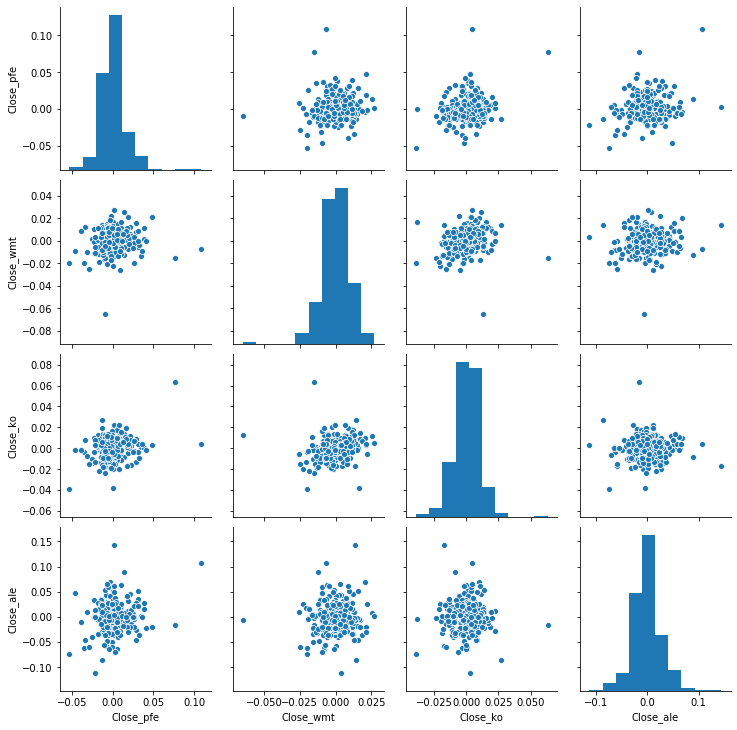

In [583]:
sns.pairplot(merged_data)

           Close_pfe  Close_wmt  Close_ko  Close_ale
Close_pfe   1.000000   0.119664  0.244990   0.183819
Close_wmt   0.119664   1.000000  0.252669   0.065495
Close_ko    0.244990   0.252669  1.000000  -0.025944
Close_ale   0.183819   0.065495 -0.025944   1.000000


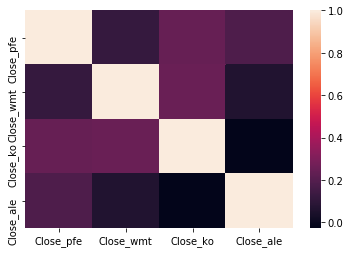

In [584]:
corr = merged_data.corr()
print(corr)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Monte Carlo Simulation of weights for assets in portfolio

Portfolio risk calculation

In [676]:
def random_weight(no_of_assets, no_of_iterations=10000):
    my_list = []
    for i in range(no_of_iterations):
        a = np.random.random(no_of_assets)
        a /= a.sum()
        my_list.append(a)
    my_list.append([0,0,0,1])
    my_list.append([0,0,1,1])
    my_list.append([0,1,0,0])
    my_list.append([1,0,0,0])
    return pd.DataFrame(my_list,columns=['PFE','WMT','KO','ALE'])
    
def portfolio_risk(cov_matrix, weights):
    mw = np.matrix(weights[['PFE','WMT','KO','ALE']])
    d = []
    for i in range(len(mw)):
        d.append(float(np.matmul(np.matmul(mw[i],np.matrix(covariation_matrix)),mw[i].transpose())))

    d = pd.DataFrame(d)
    return (d)**(1/2)

In [677]:
covariation_matrix = merged_data.cov()
weights = random_weight(4,10000)

In [678]:
weights['PFE_RETURN'] = merged_data['Close_pfe'].mean()
weights['WMT_RETURN'] = merged_data['Close_wmt'].mean()
weights['KO_RETURN'] = merged_data['Close_ko'].mean()
weights['ALE_RETURN'] = merged_data['Close_ale'].mean()

In [679]:
weights['PORTFOLIO_RETURN'] = (weights['ALE_RETURN'] * weights['ALE'])+(weights['PFE_RETURN'] * weights['PFE']) + (weights['WMT_RETURN'] * weights['WMT']) + (weights['KO_RETURN'] * weights['KO'])

In [689]:
weights['P-Risk']=portfolio_risk(covariation_matrix, weights)
minimal_risk_portfolio = weights[weights['P-Risk'] == weights['P-Risk'].min()]
max_return_portfolio = weights[weights['P-Risk'] == weights['P-Risk'].max()]
weights['Eff'] = weights['PORTFOLIO_RETURN'] / weights['P-Risk']
max_eff = weights['Eff'].max()
eff_portfolio = weights[weights['Eff'] == max_eff]
eff_portfolio

,PFE,WMT,KO,ALE,PFE_RETURN,WMT_RETURN,KO_RETURN,ALE_RETURN,PORTFOLIO_RETURN,P-Risk,Eff
7588,0.513368,0.027899,0.454429,0.004305,0.001298,-0.000075,0.000597,-0.001486,0.000929,0.010614,0.087515


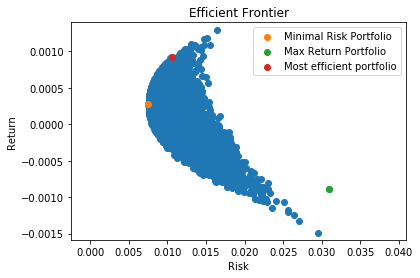

In [694]:
plt.scatter(weights['P-Risk'], weights['PORTFOLIO_RETURN'])
plt.axis([weights['P-Risk'].min() - 0.01, weights['P-Risk'].max() + 0.01, weights['PORTFOLIO_RETURN'].min()-0.0001, weights['PORTFOLIO_RETURN'].max() + 0.0001])
plt.scatter(minimal_risk_portfolio['P-Risk'], minimal_risk_portfolio['PORTFOLIO_RETURN'],label='Minimal Risk Portfolio')
plt.scatter(max_return_portfolio['P-Risk'], max_return_portfolio['PORTFOLIO_RETURN'],label='Max Return Portfolio')
plt.scatter(eff_portfolio['P-Risk'], eff_portfolio['PORTFOLIO_RETURN'],label='Most efficient portfolio')
plt.legend()
plt.title('Efficient Frontier')
plt.ylabel('Return')
plt.xlabel('Risk')
plt.show()